In [2]:
import numpy as np
import pandas as pd
from your.candidate import Candidate as Cand
import candproc_tools as ct
import sys
from matplotlib import pyplot as plt
import xarray as xr
import json
from astropy.time import Time, TimeDelta
import your
import analysis_tools as at
# from rich.pretty import Pretty
# from sigpyproc.readers import FilReader

### Modified in T3:

1. candproc_tools.py: import pandas; chunks to 2048; output starting time in read_voltage_data
2. analysis_tools.py: commented out stuff; import scipy; return stds in calc_snr_presto

In [1]:
# cand.
# etc/systemd/system/ * .service
# sudo systemctl start *.serviec

In [3]:
# downsample dedispersed pulse using ibox, then plot the same nubmer of samples
# try cand.decimate: cand.decimate('ft', 16, axis=1) freq; cand.decimate('ft', ibox, axis=0, pad=True) time.
# 128 by 128 samples 

In [ ]:
# remove freq baseline, save a vol file 

# Test .fil output

## write and read .fil

In [5]:
from your.formats.filwriter import make_sigproc_object
tab = get_cand("240324aaap.json")
cand = ct.read_proc_fil(fnfil="/hdd/data/candidates/T3/candplots/intermediate.fil", 
                        dm=tab["dm"].values[0], 
                        tcand=2.0, 
                        width=1, 
                        device=0, 
                        tstart=0,
                        tstop=4, 
                        ndm=32, 
                        dmtime_transform=True)
# cand.decimate(key = 'ft', 
#               decimate_factor = 16, 
#               axis = 1) # frequency ds
# cand.decimate(key = 'ft', 
#               decimate_factor = tab['ibox'].values[0],
#               axis = 0,
#               pad = True) # time ds
# cand.tsamp = cand.tsamp * tab['ibox'].values[0]

### downsampled pulse is all floats, could save to a fil before downsampling it. 

In [7]:
cand.data

array([[64516,     0, 64516, ...,     0, 64516,     0],
       [64516,     0, 64516, ...,     0, 64516,     0],
       [64516,     0, 64516, ...,     0, 64516,     0],
       ...,
       [64516,     0, 64516, ...,     0, 64516,     0],
       [64516,     0, 64516, ...,     0, 64516,     0],
       [64516,     0, 64516, ...,     0, 64516,     0]], dtype=uint16)

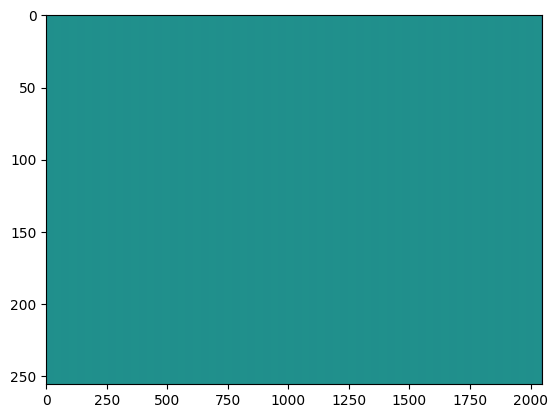

In [6]:
window_time = 256
mm = 1000
data_fil = cand.data[mm-window_time//2:mm+window_time//2, :]
data_fil = data_fil 
plt.imshow(data_fil, aspect='auto', vmax=np.mean(data_fil)+np.std(data_fil))

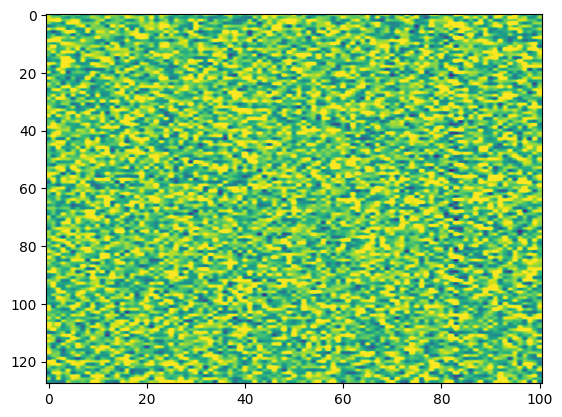

In [21]:
window_time = 128 # number of samples before and after the candidate ToA
ntime, nchans = cand.dedispersed.shape[0], cand.dedispersed.shape[1]
f_low = int(278/16) # roughly from 1300MHz to 1500MHz
f_high = nchans - int(164/16)   
data_timestream = cand.dedispersed.mean(1)
mm = np.argmax(data_timestream)

if window_time<4:
    print('Too few samples to plot')

data_timestream = data_timestream[mm-window_time//2:mm+window_time//2]
data_freqtime = cand.dedispersed[mm-window_time//2:mm+window_time//2, f_low:f_high] # roughly from 1300MHz to 1500MHz
data_freqtime = (data_freqtime - 
                 np.mean(data_freqtime, axis=0, keepdims=True))
plt.imshow(data_freqtime, aspect='auto', vmax=np.mean(data_freqtime)+np.std(data_freqtime))

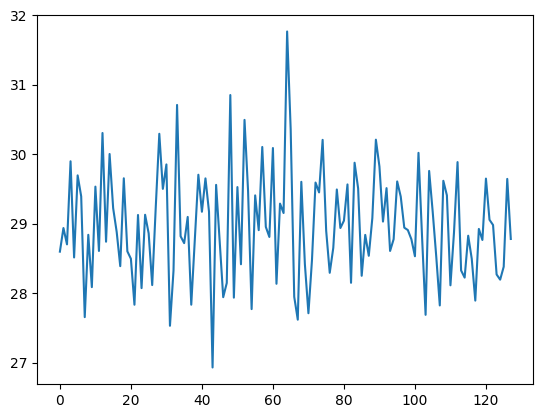

In [20]:
plt.plot(data_timestream)

In [6]:
cand.data.max()

255

In [7]:
m = mm*tab['ibox'].values[0]
print(m, mm)
print(cand.dedispersed[mm-window_time//2:mm+window_time//2, :])
print(cand.data[m-window_time*tab['ibox'].values[0]//2:m+window_time*tab['ibox'].values[0]//2, :])

294656 9208
[[27.52734375 29.81835938 25.04492188 ... 27.63867188 30.83007812
  27.18554688]
 [27.39648438 27.12304688 28.19726562 ... 28.6171875  29.58007812
  29.38867188]
 [30.27539062 30.2890625  28.48242188 ... 28.72460938 29.55664062
  28.66015625]
 ...
 [28.43164062 25.37304688 26.4921875  ... 29.98632812 27.51757812
  26.86328125]
 [30.31054688 27.69140625 27.65234375 ... 29.33203125 28.8984375
  26.72851562]
 [28.86523438 30.61914062 25.94726562 ... 31.01757812 26.68945312
  28.91015625]]
[[ 53   2   0 ...   0   0   0]
 [135   0   0 ...   0   0   0]
 [143   1   0 ...   0   0   0]
 ...
 [ 60   0   0 ...   1   0   0]
 [123   0   0 ...   0   0   0]
 [ 23   1   0 ...   3   0   0]]


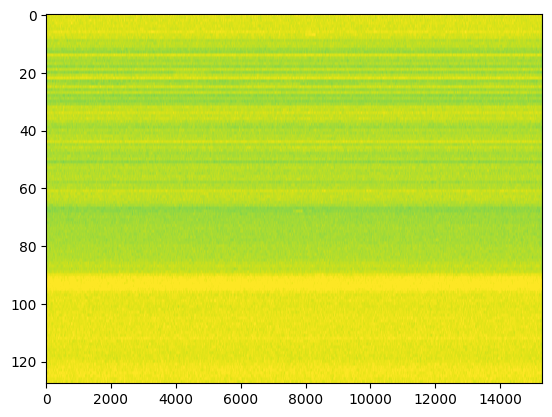

In [8]:
plt.imshow(cand.dedispersed.T, aspect='auto', vmax = np.mean(cand.dedispersed)+np.std(cand.dedispersed))

In [29]:
cand.dedispersed.astype(int)

(15296, 128)

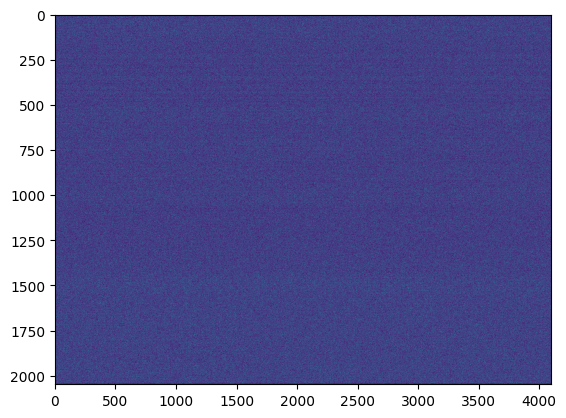

In [32]:
data_fil = cand.data[m-window_time*tab['ibox'].values[0]//2:m+window_time*tab['ibox'].values[0]//2, :]
plt.imshow(data_fil.T, aspect='auto', vmax=np.mean(data_fil)+2*np.std(data_fil))
#plt.xlim(0,120)

In [36]:
# save a .fil
# nchans = cand.dedispersed.shape[1]
# foff = -250/nchans
nchans = cand.nchans
foff = cand.foff
fch1 = cand.fch1
tsamp = cand.tsamp #/ tab['ibox'].values[0] # seconds
sigproc_object = make_sigproc_object(
                                rawdatafile="test_dedisp.fil",
                                source_name="bar",
                                nchans=nchans,
                                foff=foff,  # MHz
                                fch1=fch1,  # MHz
                                tsamp=tsamp,  # seconds
                                tstart=59246,  # MJD
                                src_raj=112233.44,  # HHMMSS.SS
                                src_dej=112233.44,  # DDMMSS.SS
                                machine_id=0,
                                nbeams=1,
                                ibeam=0,
                                nbits=8,
                                nifs=1,
                                barycentric=0,
                                pulsarcentric=0,
                                telescope_id=6,
                                data_type=0,
                                az_start=-1,
                                za_start=-1,)

sigproc_object.write_header('test_dedisp.fil')
sigproc_object.append_spectra(data_fil, 'test_dedisp.fil')



Unified Header:
  "basename": "test_dedisp"
  "bw": -250.12212994648144
  "center_freq": 1404.9389648436409
  "dec_deg": 11.375955555555556
  "dtype": "uint8"
  "fch1": 1529.93896484375
  "filelist": [
    "test_dedisp.fil"
  ]
  "filename": "test_dedisp.fil"
  "foff": -0.12212994626293039
  "format": "fil"
  "frequency_decimation_factor": 1
  "gb": 63.850899122181495
  "gl": 65.6617979813457
  "native_foff": -0.12212994626293039
  "native_nbits": 8
  "native_nchans": 2048
  "native_nspectra": 256.0
  "native_tsamp": 8.172355592250824e-06
  "nbits": 8
  "nchans": 2048
  "npol": 1
  "nspectra": 256
  "poln_order": "I"
  "ra_deg": 170.63933333333335
  "source_name": "bar"
  "time_decimation_factor": 1
  "tsamp": 8.172355592250824e-06
  "tstart": 59246.0
  "tstart_utc": "2021-02-01T00:00:00.000"



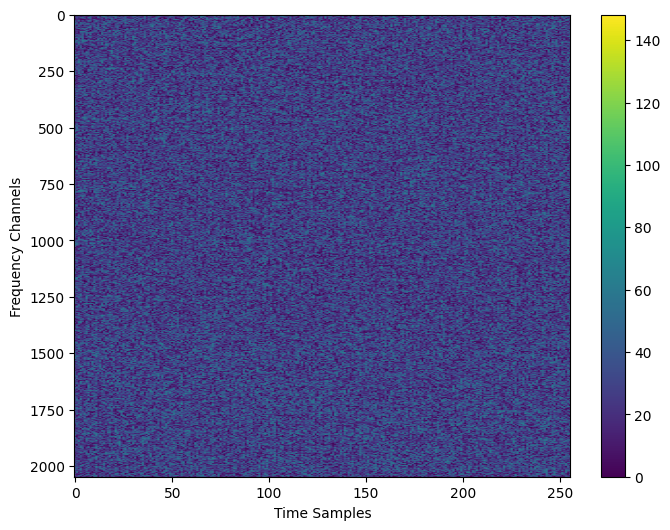

In [37]:
your_object = your.Your('test_dedisp.fil')
print(your_object.your_header)

data = your_object.get_data(0, 4096)
data.shape
plt.figure(figsize=(8, 6))
plt.imshow(data.T, aspect="auto", vmax = np.mean(data)+2*np.std(data))
plt.xlabel("Time Samples")
plt.ylabel("Frequency Channels")
#plt.xlim(0,200)
plt.colorbar()
plt.show()

## Skip intermediate.fil

In [40]:
ff = "/hdd/data/voltages/grex_dump-240325aaac.nc"
# ff = "/hdd/data/voltages/grex_dump-240322abef.nc" # netcdf fails
vol = xr.open_dataset(ff, chunks={"time":2048})
dt = (vol.time.max() - vol.time.min()) * 24 * 3600

In [41]:
vol.voltages[6000,0,:,0].values[1000:1200]

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 23:
  #000: H5Dio.c line 179 in H5Dread(): can't read data
    major: Dataset
    minor: Read failed
  #001: H5VLcallback.c line 2011 in H5VL_dataset_read(): dataset read failed
    major: Virtual Object Layer
    minor: Read failed
  #002: H5VLcallback.c line 1978 in H5VL__dataset_read(): dataset read failed
    major: Virtual Object Layer
    minor: Read failed
  #003: H5VLnative_dataset.c line 166 in H5VL__native_dataset_read(): can't read data
    major: Dataset
    minor: Read failed
  #004: H5Dio.c line 545 in H5D__read(): can't read data
    major: Dataset
    minor: Read failed
  #005: H5Dchunk.c line 2541 in H5D__chunk_read(): error looking up chunk address
    major: Dataset
    minor: Can't get value
  #006: H5Dchunk.c line 3262 in H5D__chunk_lookup(): can't query chunk address
    major: Dataset
    minor: Can't get value
  #007: H5Dbtree.c line 1008 in H5D__btree_idx_get_addr(): can't get chunk info
    major: Dataset
    m

RuntimeError: NetCDF: HDF error

In [6]:
plt.imshow(stokesi.T, aspect='auto', vmax=np.mean(stokesi.values)+np.std(stokesi.values))
plt.colorbar()

Error in callback <function flush_figures at 0x7d2f30382320> (for post_execute):


KeyboardInterrupt: 

In [4]:

# c = "240322abfj" # candidate name
c = "240324aaap" # this is not work, even the .nc... all 65416
f = "/hdd/data/voltages/grex_dump-"+c+".nc" # voltage file
JSON = c+".json"
out_path = "./"
tab = get_cand(JSON)
t0 = tab["mjds"].values[0] # ToA of the candidate

dt = 8.192e-6 # s 
Dt = 4.15 * tab["dm"].values[0] * (1/1.28**2 - 1/1.53**2) / 1e3 # delay in seconds given DM
# dur = (vol.time.max().values - vol.time.min().values) * 86400 # duration of the voltage file in seconds

(stokesi, T0) = ct.read_voltage_data(f, timedownsample=None, freqdownsample=None)
print('Done reading .nc and calc stokes I')


Done reading .nc and calc stokes I


Done writing to .fil


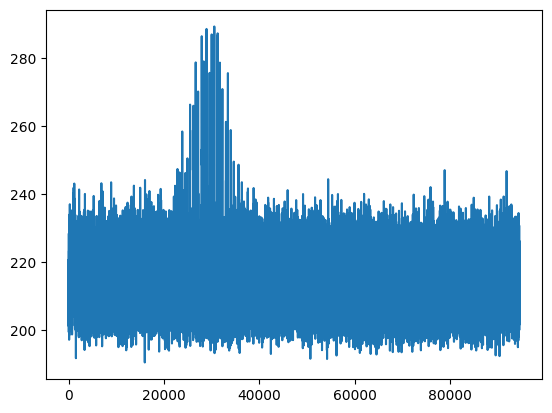

In [4]:
dt = 8.192e-6
intermediate = './test.fil'
window_width = int(Dt*2 / dt) # number of samples in the pulse window
mm = int(stokesi.shape[0]/2)  # (t0-T0)*86400/dt 
cand_disp = stokesi[(mm-window_width//2):(mm+window_width//2), :] # dispersed candidate in xarray dataarray format.
plt.plot(cand_disp.values.mean(1))
ct.write_sigproc(intermediate, cand_disp)
print('Done writing to .fil')


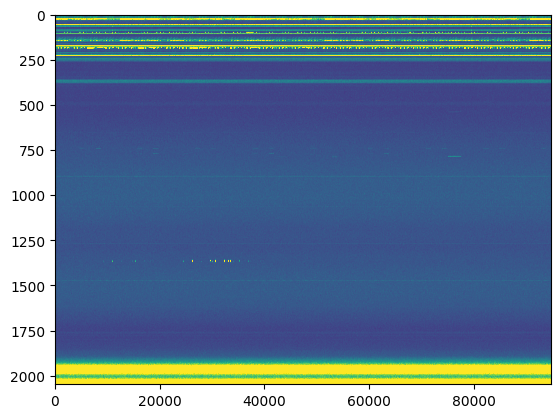

In [5]:
plt.imshow(cand_disp.T, aspect='auto', vmax=np.mean(cand_disp)+np.std(cand_disp))

In [6]:

cand = ct.read_proc_fil(fnfil=intermediate, 
                        dm=tab["dm"].values[0], 
                        tcand=2.0, 
                        width=1, 
                        device=0, 
                        tstart=0,
                        tstop=(cand_disp.time.max()-cand_disp.time.min()).values*86400, 
                        ndm=32, 
                        dmtime_transform=True)
print('Done dedispersing')

ValueError: Unsupported number of bits 64

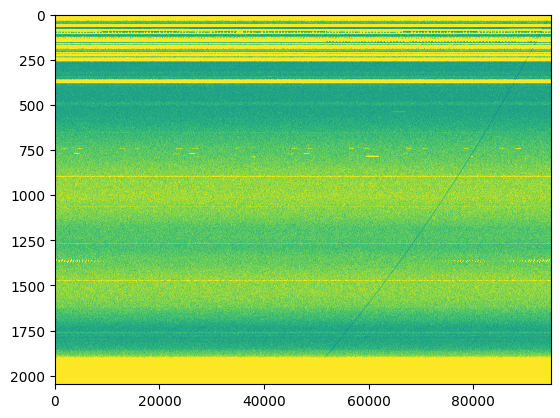

In [11]:
plt.imshow(cand.dedispersed.T, aspect='auto', vmax=np.mean(cand.dedispersed)+np.std(cand.dedispersed))

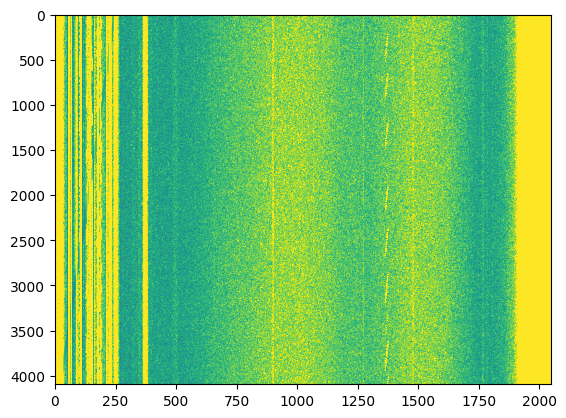

In [15]:
# generate smaller window of the dedispersed pulse and save to .fil
# (before downsampling)
window_time = 128 * tab['ibox'].values[0] 
data_timestream = cand.dedispersed.mean(1)
mm = np.argmax(data_timestream) # eventually this will be replaced with actual ToA 
data_freqtime = cand.dedispersed[mm-window_time//2:mm+window_time//2, :] 
plt.imshow(data_freqtime, aspect='auto', vmax = np.mean(data_freqtime)+2*np.std(data_freqtime))

# write to .fil
from your.formats.filwriter import make_sigproc_object

fnfilout = "./test_dedisp.fil"
nchans = cand.nchans
foff = cand.foff
fch1 = cand.fch1
tsamp = cand.tsamp 
sigproc_object = make_sigproc_object(
                                rawdatafile=fnfilout,
                                source_name="bar",
                                nchans=nchans,
                                foff=foff,  # MHz
                                fch1=fch1,  # MHz
                                tsamp=tsamp,  # seconds
                                tstart=59246,  # MJD
                                src_raj=112233.44,  # HHMMSS.SS
                                src_dej=112233.44,  # DDMMSS.SS
                                machine_id=0,
                                nbeams=1,
                                ibeam=0,
                                nbits=32,
                                nifs=1,
                                barycentric=0,
                                pulsarcentric=0,
                                telescope_id=6,
                                data_type=0,
                                az_start=-1,
                                za_start=-1,)

sigproc_object.write_header(fnfilout)
sigproc_object.append_spectra(data_freqtime, fnfilout)

Unified Header:
  "basename": "cand240325aaad"
  "bw": -250.12212994648144
  "center_freq": 1404.9389648436409
  "dec_deg": 11.375955555555556
  "dtype": "uint16"
  "fch1": 1529.93896484375
  "filelist": [
    "/hdd/data/candidates/T3/candfils/cand240325aaad.fil"
  ]
  "filename": "/hdd/data/candidates/T3/candfils/cand240325aaad.fil"
  "foff": -0.12212994626293039
  "format": "fil"
  "frequency_decimation_factor": 1
  "gb": 63.850899122181495
  "gl": 65.6617979813457
  "native_foff": -0.12212994626293039
  "native_nbits": 16
  "native_nchans": 2048
  "native_nspectra": 128.0
  "native_tsamp": 8.172355592250824e-06
  "nbits": 16
  "nchans": 2048
  "npol": 1
  "nspectra": 128
  "poln_order": "I"
  "ra_deg": 170.63933333333335
  "source_name": "bar"
  "time_decimation_factor": 1
  "tsamp": 8.172355592250824e-06
  "tstart": 59246.0
  "tstart_utc": "2021-02-01T00:00:00.000"



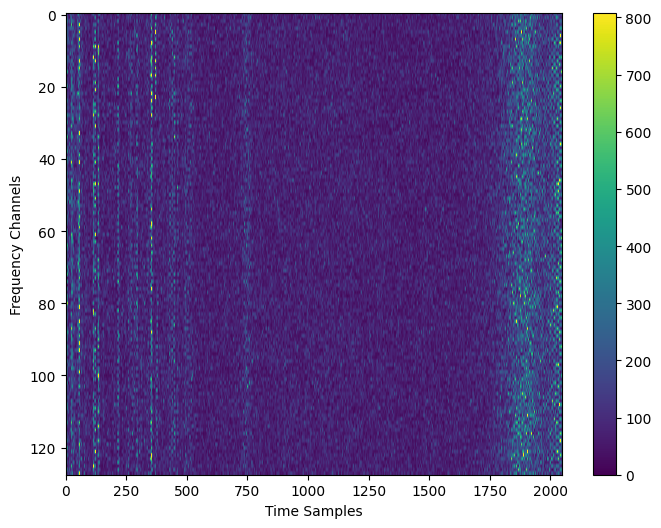

In [82]:
### test the output .fil
your_object = your.Your('/hdd/data/candidates/T3/candfils/cand240325aaad.fil')
print(your_object.your_header)

data = your_object.get_data(0, 4096)
data.shape
plt.figure(figsize=(8, 6))
plt.imshow(data, aspect="auto", vmax = np.mean(data)+2*np.std(data))
plt.xlabel("Time Samples")
plt.ylabel("Frequency Channels")
#plt.xlim(0,200)
plt.colorbar()
plt.show()

In [17]:
### downsampling
cand.decimate(key = 'ft', 
              decimate_factor = 16, 
              axis = 1) # frequency ds
cand.decimate(key = 'ft', 
              decimate_factor = tab['ibox'].values[0],
              axis = 0,
              pad = True) # time ds
cand.decimate(key='dmt',
              decimate_factor = tab['ibox'].values[0],
              axis = 1,
              pad = True)
cand.tsamp = cand.tsamp * tab['ibox'].values[0]
print('Done downsampling')
print(cand.dedispersed.shape)
print(cand.dmt.shape)

# now could pass it onto plot_grex()

Done downsampling
(2965, 128)
(256, 2965)


In [6]:
Dt = 4.15 * tab["dm"].values[0] * (1/1.28**2 - 1/1.53**2) / 1e3 # delay in seconds given DM
window = int(Dt*2 / 8.192e-6)
print(Dt*2)

0.7753392969601034


In [24]:
### check failure
tab = get_cand("240322abfj.json")
#fnfil="/hdd/data/candidates/T3/candfils/cand240322abfj.fil"
fnfil = "dedisp.fil"
cand = ct.read_proc_fil(fnfil=fnfil, 
                        dm=tab["dm"].values[0], 
                        tcand=2.0, 
                        width=1, 
                        device=0, 
                        tstart=0,
                        tstop=Dt*2, 
                        ndm=32, 
                        dmtime_transform=True)
print('Done dedispersing')

Done dedispersing


In [25]:
### downsampling
cand.decimate(key = 'ft', 
              decimate_factor = 16, 
              axis = 1) # frequency ds
cand.decimate(key = 'ft', 
              decimate_factor = tab['ibox'].values[0],
              axis = 0,
              pad = True) # time ds
cand.decimate(key='dmt',
              decimate_factor = tab['ibox'].values[0],
              axis = 1,
              pad = True)
cand.tsamp = cand.tsamp * tab['ibox'].values[0]
print('Done downsampling')
print(cand.dedispersed.shape)
print(cand.dmt.shape)


Done downsampling
(2965, 128)
(256, 2965)


In [36]:
cand.data.max()

9.1121e-41

mm, window =  29 58
[ 0.          0.26160361  0.52320722  0.78481083  1.04641444  1.30801805
  1.56962166  1.83122527  2.09282888  2.35443249  2.6160361   2.8776397
  3.13924331  3.40084692  3.66245053  3.92405414  4.18565775  4.44726136
  4.70886497  4.97046858  5.23207219  5.4936758   5.75527941  6.01688302
  6.27848663  6.54009024  6.80169385  7.06329746  7.32490107  7.58650468
  7.84810829  8.10971189  8.3713155   8.63291911  8.89452272  9.15612633
  9.41772994  9.67933355  9.94093716 10.20254077 10.46414438 10.72574799
 10.9873516  11.24895521 11.51055882 11.77216243 12.03376604 12.29536965
 12.55697326 12.81857687 13.08018048 13.34178409 13.60338769 13.8649913
 14.12659491 14.38819852 14.64980213 14.91140574]


/home/jupyter-user/T3plot/analysis_tools.py:139: RuntimeWarning: divide by zero encountered in scalar divide
  snr_ = std_chunk[-1] / stds
/tmp/ipykernel_703932/4164483062.py:201: RuntimeWarning: divide by zero encountered in divide
  plt.plot(times, (data_timestream-np.mean(data_timestream))/stds, lw=1., color='black')
/tmp/ipykernel_703932/4164483062.py:201: RuntimeWarning: invalid value encountered in divide
  plt.plot(times, (data_timestream-np.mean(data_timestream))/stds, lw=1., color='black')


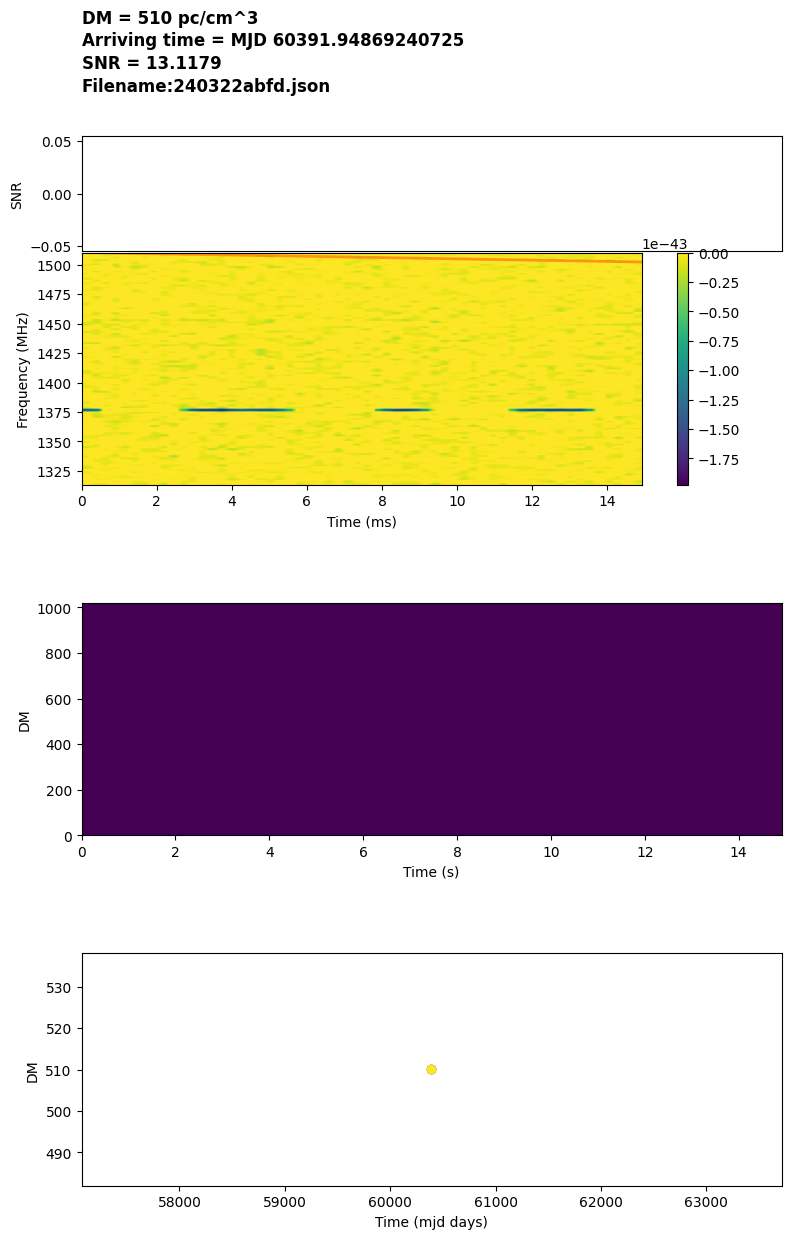

In [31]:
(ds, s) = plot_grex(cand, 123, tab, "240322abfd.json")

# cand_plotter.py

In [3]:
### 03/22/2024 
from your.formats.filwriter import make_sigproc_object

def get_cand(JSON):
    f = open('/hdd/data/candidates/T2/'+JSON)
    data = json.load(f)
    tab = pd.json_normalize(data[JSON.split(".")[0]], meta=['id'])
    
    f.close()
    return(tab)
    

def gen_cand(fn_vol, fn_filout, JSON): # tab - json file
    """
    fn_vol = input voltage filename
    fn_filout = output .fil filename
    JSON = candidate .json filename (e.g. 240321aazm.json)
    --------
    Reads in a raw voltage file
    Calculates Stokes I 
    Picks a window given ToA (save to a temporary .fil)
    Dedisperses the window; Generatese DMtime
    Saves dedispersed window to a .fil file
    Downsamples the window
    --------
    Returns:
    cand = Candidate object by the your package? 
    T0 = start time of the input voltage file in MJD
    tab = .json table
    """

    out_path = "./"
    tab = get_cand(JSON)
    t0 = tab["mjds"].values[0] # ToA of the candidate
    dt = 8.192e-6 # s 
    Dt = 4.15 * tab["dm"].values[0] * (1/1.28**2 - 1/1.53**2) / 1e3 # delay in seconds given DM
    # dur = (vol.time.max().values - vol.time.min().values) * 86400 # duration of the voltage file in seconds
    
    (stokesi, T0, dur) = ct.read_voltage_data(fn_vol, timedownsample=None, freqdownsample=None)
    print('Done reading .nc and calc stokes I')
    # plt.plot(stokesi.values.mean(1))
    # plt.show()

    dt = 8.192e-6
    intermediate = 'intermediate.fil'
    window_width = int(Dt*2 / dt) # number of samples in the pulse window
    print('window size = ', window_width)
    # mm = int(stokesi.shape[0]/2) # temporarily choose the center of stokesi  # (t0-T0)*86400/dt 
    t_in_nc = (t0-T0)*86400 
    print('time = ', t_in_nc)
    print('Duration = ', dur)
    dur = int(dur/dt)
    print('samples = ', dur)
    print('stokesi shape = ', stokesi.shape)
    if t_in_nc > dur*dt: # not captured in .nc, pick a random time interval to plot for now, need to log errors later.
        mm = stokesi.shape[0]//2
        print('not in .nc; mm = ', mm)
    else: # if in the .nc file
        mm = int(t_in_nc / dt) # number of samples after the start of .nc file
        print('in .nc! mm = ', mm)
        if (mm<(window_width//2)):
            window_width = int(2*mm)
            print('toward the beginning')
        elif ((dur-mm)<window_width//2):
            window_width = (dur-mm)
            print('toward the end', dur-mm)

    if window_width < 10:
        print("Too few samples!")
        return
    print('mm = ', mm, 'windowsize = ', window_width)
    
    cand_disp = stokesi[(mm-window_width//2):(mm+window_width//2), :] # dispersed candidate in xarray dataarray format.

    print('start time = ', T0+(mm-window_width//2)*dt/86400)
    ct.write_sigproc(intermediate, cand_disp, t_start=T0+(mm-window_width//2)*dt/86400) 
    print('Done writing to a temporary .fil')
    
    cand = ct.read_proc_fil(fnfil=intermediate, 
                            dm=tab["dm"].values[0], 
                            tcand=2.0, 
                            width=1, 
                            device=0, 
                            tstart=0,
                            tstop=(cand_disp.time.max()-cand_disp.time.min()).values*86400, 
                            ndm=32, 
                            dmtime_transform=True)
    print('Done dedispersing')

    # generate a smaller window of the dedispersed pulse and save to .fil
    # (before downsampling)
    window_time = 128 * tab['ibox'].values[0] 
    data_timestream = cand.dedispersed.mean(1)
    mm = np.argmax(data_timestream) # eventually this will be replaced with actual ToA 
    data_freqtime = cand.dedispersed[mm-window_time//2:mm+window_time//2, :] 
    
    # write to .fil
    nchans = cand.nchans
    foff = cand.foff
    fch1 = cand.fch1
    tsamp = cand.tsamp 
    sigproc_object = make_sigproc_object(
                                    rawdatafile=fn_filout,
                                    source_name="bar",
                                    nchans=nchans,
                                    foff=foff,  # MHz
                                    fch1=fch1,  # MHz
                                    tsamp=tsamp,  # seconds
                                    tstart=t0,  # MJD #### need to update this!
                                    src_raj=112233.44,  # HHMMSS.SS
                                    src_dej=112233.44,  # DDMMSS.SS
                                    machine_id=0,
                                    nbeams=1,
                                    ibeam=0,
                                    nbits=8,
                                    nifs=1,
                                    barycentric=0,
                                    pulsarcentric=0,
                                    telescope_id=6,
                                    data_type=0,
                                    az_start=-1,
                                    za_start=-1,)

    
    sigproc_object.write_header(fn_filout)
    sigproc_object.append_spectra(data_freqtime, fn_filout)

    ### downsampling
    cand.decimate(key = 'ft', 
                  decimate_factor = 16, 
                  axis = 1) # frequency ds
    cand.decimate(key = 'ft', 
                  decimate_factor = tab['ibox'].values[0],
                  axis = 0,
                  pad = True) # time ds
    cand.decimate(key='dmt',
                  decimate_factor = tab['ibox'].values[0],
                  axis = 1,
                  pad = True)
    cand.tsamp = cand.tsamp * tab['ibox'].values[0]
    print('Done downsampling')
    print(cand.dedispersed.shape)
    print(cand.dmt.shape)
    return(cand, T0, dur*dt, tab)



def plot_grex(cand, T0, dur, tab, JSON): 

    """
    cand = the first output from gen_cand() function
    T0 = start time of the voltage file in MJD, the second output from gen_cand() function
    dur = duration of netcdf file in seconds 
    tab = candidate .json table from gen_cand()
    JSON = .json filename
    """
    
    window_time = 128 # number of samples before and after the candidate ToA
    ntime, nchans = cand.dedispersed.shape[0], cand.dedispersed.shape[1]
    f_low = int(278/16) # roughly from 1300MHz to 1500MHz
    f_high = nchans - int(164/16)    
    
    cluster = pd.read_csv("/hdd/data/candidates/T2/cluster_output.csv")
    # snr,if,specnum,mjds,ibox,idm,dm,ibeam,cl,cntc,cntb,trigger
    this_cand = np.where(np.abs(cluster['mjds']-tab["mjds"].values[0])<30./86400)[0] # candidates nearby within 10s
    
    data_timestream = cand.dedispersed.mean(1)
    # mm = np.argmax(data_timestream)
    # mm = len(data_timestream)//2

    t_in_nc = (tab['mjds'].values[0] - cand.tstart) * 86400 # seconds after the start of the intermediate .fil
    print('Time in .nc = ', t_in_nc)
    l = cand.dedispersed.shape[0] # length of .fil file
    print('length of timestream = ', l)
    if t_in_nc > l*cand.tsamp: # not captured in .fil, pick a random time interval
        mm = len(data_timestream)//2 # update this and log errors. 
        print('not in .nc; mm = ', mm)
    else: # if in the .nc file
        mm = int(t_in_nc / cand.tsamp)
        print('in .nc! mm = ', mm)
        if (mm<(window_time//2)):
            window_time = int(2*mm)
            print('toward the beginning')
        elif ((l-mm)<window_time//2):
            window_time = (l-mm)
            print('toward the end')
    # l = data_timestream.shape[0]
    # if (mm<window_time//2):
    #     window_time = int(2*mm)
    # elif ((l-mm)<window_time//2):
    #     window_time = (l-mm)
    print('mm, window = ', mm, window_time)
    if window_time<4:
        print('Too few samples to plot')
        return
    
    data_timestream = data_timestream[mm-window_time//2:mm+window_time//2]
    data_freqtime = cand.dedispersed[mm-window_time//2:mm+window_time//2, f_low:f_high] # roughly from 1300MHz to 1500MHz
    data_freqtime = (data_freqtime - 
                     np.mean(data_freqtime, axis=0, keepdims=True))

    data_freqtime = data_freqtime.T
    data_dmt = cand.dmt[:, mm-window_time//2:mm+window_time//2]
    data_dmt = (data_dmt - 
                np.mean(data_dmt, axis=1, keepdims=True))

    times = np.linspace(0,cand.tsamp*ntime,ntime) * 1e3 # Convert into milliseconds
    times = times[mm-window_time//2:mm+window_time//2]
    tmin, tmax = times[0], times[-1]
    freqs = np.linspace(cand.fch1+(nchans-f_low)*cand.foff*16, cand.fch1+cand.foff*16*(nchans-f_high), f_high-f_low)
    freqmin, freqmax = freqs[0], freqs[-1]
    # print(freqs, freqs.shape)

    dt = 4.15 * cand.dm * (1/(freqmin/1e3)**2 - 1/(freqmax/1e3)**2) / 1e3 / cand.tsamp # number of samples 
    data_freqtime_ud = cand.data[mm:mm+int(dt*1.3), f_low:f_high] # dispersed pulse
    # data_freqtime_ud = data_freqtime_ud - 
    #                     np.mean(data_freqtime_ud, axis=0, keepdims=True)
    data_freqtime_ud = data_freqtime_ud.T

    # data_favg = data_freqtime.mean(axis=0) = data_timestream
    snr_tools = at.SNR_Tools()
    stds = snr_tools.calc_snr_presto(data_timestream)[1]
    data_tavg = data_freqtime.mean(axis=1)

    fig = plt.figure(figsize=(10,15))
    grid = plt.GridSpec(9, 6)
    # first row, collapse frequency 
    plt.subplot(grid[0, :6])
    plt.plot(times, (data_timestream-np.mean(data_timestream))/stds, lw=1., color='black')
    plt.ylabel('SNR')
    plt.xlim(times.min(), times.max())
    plt.xticks([], [])

    # dedispersed pulse
    plt.subplot(grid[1:3, :6])
    vmax = np.mean(data_freqtime) + 2*np.std(data_freqtime)
    # plt.imshow(data_freqtime, aspect='auto', vmax=vmax,  extent=(times.min()-t0, times.max()-t0, freqs.min(), freqs.max()))
    plt.imshow(data_freqtime, aspect='auto', vmax=vmax,  extent=(times.min(), times.max(), freqs.min(), freqs.max()))
    DM0_delays = tmin + cand.dm * 4.15E6 * (freqmin**-2 - freqs**-2) # zero DM sweep
    plt.plot(DM0_delays, freqs, c='r', lw='2', alpha=0.35)
    #plt.xlabel('Time (s) + {:.3f} seconds'.format(t0))
    plt.xlabel('Time (ms) + MJD {}'.format(cand.tstart), fontsize=12)
    plt.ylabel('Frequency (MHz)')
    plt.xlim(tmin, tmax)

    # DM vs. time
    plt.subplot(grid[4:6, 0:6])
    # plt.imshow(data_dmt, aspect='auto', interpolation='nearest', extent=(times.min()-t0, times.max()-t0, 0, 450))
    plt.imshow(data_dmt, aspect='auto', interpolation='nearest', extent=(times.min(), times.max(), 0, 2*cand.dm))
    #plt.colorbar()
    # plt.xlabel('Time (s) + {:.3f} seconds'.format(t0))
    plt.xlabel('Time (s) + MJD {}'.format(cand.tstart), fontsize=12)
    plt.ylabel('DM')
    
    # DM vs. MJD in cluster_output.csv
    plt.subplot(grid[7:9, 0:6])
    # plt.scatter(cluster["mjds"][this_cand].values, cluster["dm"][this_cand].values, c=cluster['snr'][this_cand].values, s=cluster['snr'][this_cand].values* 100/np.max(cluster["snr"][this_cand].values))
    plt.scatter(cluster["mjds"][this_cand].values, cluster["dm"][this_cand].values, c=cluster['snr'][this_cand].values)
    # plt.scatter(tab['mjds'].values, tab['dm'].values, c=tab['snr'].values, s=100)
    # plt.colorbar()
    #plt.xlabel('Time (s) + {:.3f} seconds + MJD {}'.format(t0, T0))
    plt.xlabel('Time (MJD)')
    plt.ylabel('DM')


    # doesn't seem to work?
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.8, 
                        top=0.8, 
                        wspace=0.05, 
                        hspace=0.01)

    fig.text(0.1, 0.875, 'DM = {} pc/cm^3'.format(tab["dm"].values[0]),
             fontsize = 12,fontweight='semibold')
    fig.text(0.1, 0.86, 'Arriving time = MJD {}'.format(tab['mjds'].values[0]),
             fontsize = 12,fontweight='semibold')
    fig.text(0.1, 0.845, 'SNR = {}'.format(tab['snr'].values[0]),
             fontsize = 12,fontweight='semibold')
    fig.text(0.1,0.83, 'Filename:'+JSON,
             fontsize = 12,fontweight='semibold')

    if ((tab['mjds'].values[0]-T0)*86400>dur):
        fig.text(0.55, 0.875, "Candidate not in this NetCDF file!", color='red')
    
    plt.show()

    return()

(256, 18738)

In [13]:
c = "240326aacf" # candidate name
f = "/hdd/data/voltages/grex_dump-"+c+".nc" # voltage file
(cand, T0, dur, tab) = gen_cand(f, "dedisp.fil", c+'.json')

Done reading .nc and calc stokes I
window size =  18694
time =  28.40313941705972
Duration =  17.179869348183274
samples =  2097152
stokesi shape =  (2097152, 2048)
not in .nc; mm =  1048576
mm =  1048576 windowsize =  18694
start time =  60395.72157051186
Done writing to a temporary .fil
Done dedispersing
Done downsampling
(18738, 128)
(256, 18738)


60395.72147197755            mjds     snr  ibox       dm  ibeam  cntb  cntc  specnum
0  60395.721801  462.41     1  100.734      0     1   138  2735768
Time in .nc =  19.889775314368308
length of timestream =  18738
not in .nc; mm =  9369
mm, window =  9369 128


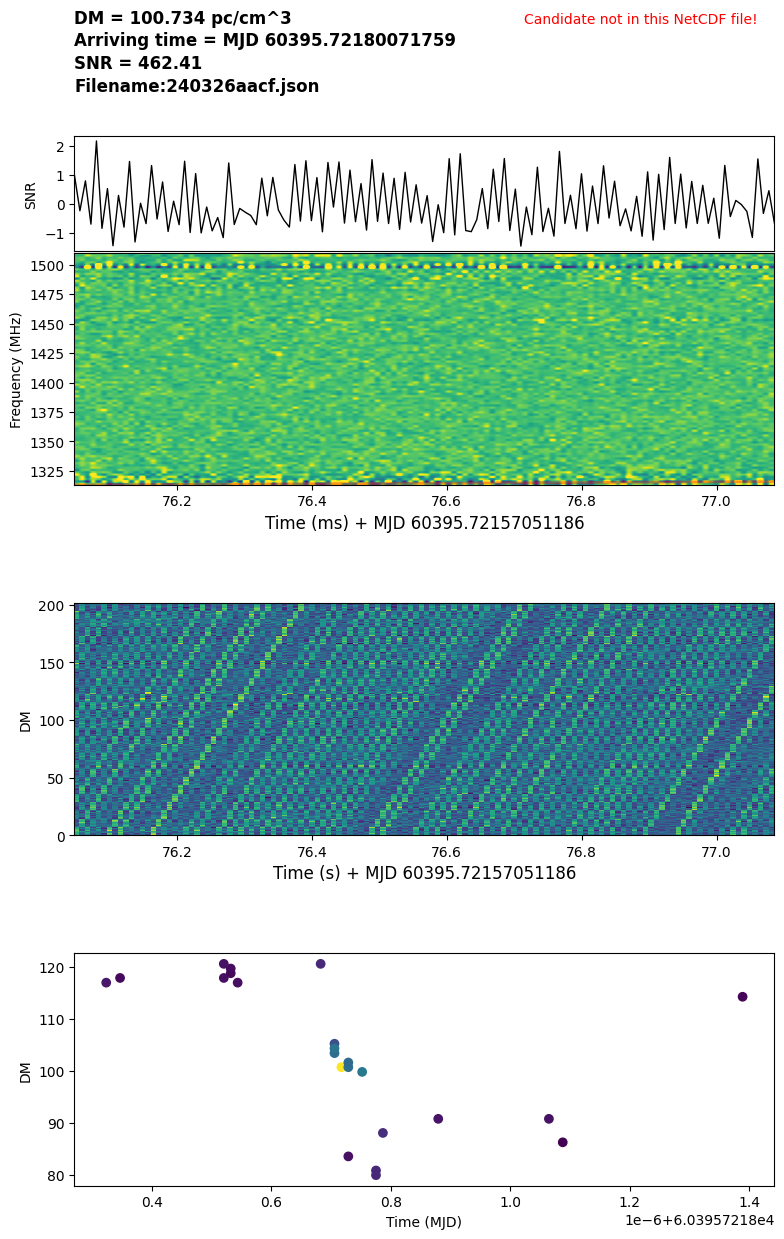

()

In [15]:
print(T0, tab)
plot_grex(cand, T0, dur, tab, c+".json")

In [17]:
5e-7*86400

0.043199999999999995

In [20]:
### liam modified 
def get_cand(JSON):
    f = open('/hdd/data/candidates/T2/'+JSON)
    data = json.load(f)
    tab = pd.json_normalize(data[JSON.split(".")[0]], meta=['id'])
    
    f.close()
    return(tab)
    

def gen_cand(fn_vol, JSON): # tab - json file
    """
    fn_vol = input voltage filename
    fn_filout = output .fil filename
    JSON = candidate .json filename (e.g. 240321aazm.json)
    --------
    Reads in a raw voltage file
    Calculates Stokes I 
    Picks a window given ToA 
    Dedisperses the window; Generatese DMtime
    Saves dedispersed window to a .fil file
    Downsamples the window
    --------
    Returns:
    cand = Candidate object by the your package? 
    T0 = start time of the input voltage file in MJD
    tab = .json table
    """
    out_path = "./"
    tab = get_cand(JSON)
    vol = xr.open_dataset(fn_vol, chunks={"time":2048})
    T0 = vol.time.min().values # start time in mjd
    t0 = tab["mjds"].values[0] # ToA of the candidate
    print(T0)

    Dt = 4.15 * tab["dm"].values[0] * (1/1.3**2 - 1/1.5**2) / 1e3 # delay in seconds given DM
    dur = (vol.time.max().values - vol.time.min().values) * 86400 # duration of the voltage file in seconds
    
    (stokesi, T0) = ct.read_voltage_data(fn_vol, timedownsample=None, freqdownsample=None)
    print('Done reading .nc and calc stokes I')
    intermediate = "intermediate.fil"
    ct.write_sigproc(intermediate, stokesi)
    print('Done writing to .fil')

    # ### eventually after we fix the time gap
    # if ((t0-T0)*86400-Dt)>0:
    #     tstart = (t0-T0)*86400-Dt
    # else: tstart = 0
    # if (tstart+Dt*2)<dur:
    #     tend = tstart+Dt*2
    # else: tend = dur

    # cand = ct.read_proc_fil(fnfil=intermediate, 
    #                         dm=tab["dm"].values[0], 
    #                         tcand=2.0, 
    #                         width=1, 
    #                         device=0, 
    #                         tstart=tstart, ## change here
    #                         tstop=tend, 
    #                         ndm=32, 
    #                         dmtime_transform=True)

    cand = ct.read_proc_fil(fnfil=intermediate, 
                            dm=tab["dm"].values[0], 
                            tcand=2.0, 
                            width=1, 
                            device=0, 
                            tstart=0,
                            tstop=4, 
                            ndm=32, 
                            dmtime_transform=True)
    print('Done dedispersing')
    cand.decimate(key = 'ft', 
                  decimate_factor = 16, 
                  axis = 1) # frequency ds
    cand.decimate(key = 'ft', 
                  decimate_factor = tab['ibox'].values[0],
                  axis = 0,
                  pad = True) # time ds
    cand.decimate(key='dmt',
                  decimate_factor = tab['ibox'].values[0],
                  axis = 1,
                  pad = True)
    cand.tsamp = cand.tsamp * tab['ibox'].values[0]
    print('Done downsampling')
    print(cand.dedispersed.shape)
    print(cand.dmt.shape)
    
    # save to .fil 
    
    
    return(cand, T0, tab)


def plot_grex(cand, T0, tab, JSON): 

    """
    cand = the first output from gen_cand() function
    T0 = start time of the voltage file in MJD, the second output from gen_cand() function
    tab = candidate .json table from gen_cand()
    JSON = .json filename
    """
    
    window_time = 128 # number of samples before and after the candidate ToA
    ntime, nchans = cand.dedispersed.shape[0], cand.dedispersed.shape[1]
    f_low = int(278/16) # roughly from 1300MHz to 1500MHz
    f_high = nchans - int(164/16)    
    
    cluster = pd.read_csv("/hdd/data/candidates/T2/cluster_output.csv")
    # snr,if,specnum,mjds,ibox,idm,dm,ibeam,cl,cntc,cntb,trigger
    this_cand = np.where(np.abs(cluster['mjds']-tab["mjds"].values[0])<30./86400)[0] # candidates nearby within 10s
    
    data_timestream = cand.dedispersed.mean(1)
    mm = np.argmax(data_timestream)
    if (mm<window_time/2):
        mmx = window_time/2
    elif (mm<abs(data_timestream.shape[0]-window_time/2)):
        mmx = data_timestream.shape[0] - window_time//2

    if window_time<4:
        print('Too few samples to plot')
        return
    
    data_timestream = data_timestream[mm-window_time//2:mm+window_time//2]
    data_freqtime = cand.dedispersed[mm-window_time//2:mm+window_time//2, f_low:f_high] # roughly from 1300MHz to 1500MHz
    data_freqtime = (data_freqtime - 
                     np.mean(data_freqtime, axis=0, keepdims=True))

    data_freqtime = data_freqtime.T
    data_dmt = cand.dmt[:, mm-window_time//2:mm+window_time//2]
    data_dmt = (data_dmt - 
                np.mean(data_dmt, axis=1, keepdims=True))

    times = np.linspace(0,cand.tsamp*ntime,ntime) * 1e3 # Convert into milliseconds
    times = times[mm-window_time//2:mm+window_time//2]
    tmin, tmax = times[0], times[-1]
    freqs = np.linspace(cand.fch1+(nchans-f_low)*cand.foff*16, cand.fch1+cand.foff*16*(nchans-f_high), f_high-f_low)
    freqmin, freqmax = freqs[0], freqs[-1]
    # print(freqs, freqs.shape)

    dt = 4.15 * cand.dm * (1/(freqmin/1e3)**2 - 1/(freqmax/1e3)**2) / 1e3 / cand.tsamp # number of samples 
    data_freqtime_ud = cand.data[mm:mm+int(dt*1.3), f_low:f_high] # dispersed pulse
    # data_freqtime_ud = data_freqtime_ud - 
    #                     np.mean(data_freqtime_ud, axis=0, keepdims=True)
    data_freqtime_ud = data_freqtime_ud.T

    # data_favg = data_freqtime.mean(axis=0) = data_timestream
    snr_tools = at.SNR_Tools()
    stds = snr_tools.calc_snr_presto(data_timestream)[1]
    data_tavg = data_freqtime.mean(axis=1)

    fig = plt.figure(figsize=(10,15))
    grid = plt.GridSpec(9, 6)
    # first row, collapse frequency 
    plt.subplot(grid[0, :6])
    plt.plot(times, (data_timestream-np.mean(data_timestream))/stds, lw=1., color='black')
    plt.ylabel('SNR')
    plt.xlim(times.min(), times.max())
    plt.xticks([], [])

    # dedispersed pulse
    plt.subplot(grid[1:3, :6])
    vmax = np.mean(data_freqtime) + 2*np.std(data_freqtime)
    # plt.imshow(data_freqtime, aspect='auto', vmax=vmax,  extent=(times.min()-t0, times.max()-t0, freqs.min(), freqs.max()))
    plt.imshow(data_freqtime, aspect='auto', vmax=vmax,  extent=(times.min(), times.max(), freqs.min(), freqs.max()))
    DM0_delays = tmin + cand.dm * 4.15E6 * (freqmin**-2 - freqs**-2)
    plt.plot(DM0_delays, freqs[::-1], c='r', lw='2', alpha=0.35)
    #plt.xlabel('Time (s) + {:.3f} seconds'.format(t0))
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (MHz)')
    plt.xlim(tmin, tmax)

    # DM vs. time
    plt.subplot(grid[4:6, 0:6])
    # plt.imshow(data_dmt, aspect='auto', interpolation='nearest', extent=(times.min()-t0, times.max()-t0, 0, 450))
    plt.imshow(data_dmt, aspect='auto', interpolation='nearest', extent=(times.min(), times.max(), 0, 450))
    #plt.colorbar()
    # plt.xlabel('Time (s) + {:.3f} seconds'.format(t0))
    plt.xlabel('Time (s)')
    plt.ylabel('DM')
    
    # DM vs. MJD in cluster_output.csv
    plt.subplot(grid[7:9, 0:6])
    # plt.scatter(cluster["mjds"][this_cand].values, cluster["dm"][this_cand].values, c=cluster['snr'][this_cand].values, s=cluster['snr'][this_cand].values* 100/np.max(cluster["snr"][this_cand].values))
    plt.scatter(cluster["mjds"][this_cand].values, cluster["dm"][this_cand].values, c=cluster['snr'][this_cand].values)
    # plt.colorbar()
    #plt.xlabel('Time (s) + {:.3f} seconds + MJD {}'.format(t0, T0))
    plt.xlabel('Time (mjd days)')
    plt.ylabel('DM')


    # doesn't seem to work?
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.8, 
                        top=0.8, 
                        wspace=0.05, 
                        hspace=0.01)

    fig.text(0.1, 0.875, 'DM = {} pc/cm^3'.format(tab["dm"].values[0]),
             fontsize = 12,fontweight='semibold')
    fig.text(0.1, 0.86, 'Arriving time = MJD {}'.format(tab['mjds'].values[0]),
             fontsize = 12,fontweight='semibold')
    fig.text(0.1, 0.845, 'SNR = {}'.format(tab['snr'].values[0]),
             fontsize = 12,fontweight='semibold')
    fig.text(0.1,0.83, 'Filename:'+JSON,
             fontsize = 12,fontweight='semibold')
    
    
    plt.show()

    return()

In [21]:
c = "240324aaap" # candidate name
f = "/hdd/data/voltages/grex_dump-"+c+".nc" # voltage file
(cand, T0, tab) = gen_cand(f, c+'.json')
print(T0, tab)
plot_grex(cand, T0, tab, c+".json")

60393.90463459721
Done reading .nc and calc stokes I
Done writing to .fil
Done dedispersing
Done downsampling
(15296, 128)
(256, 15296)
60393.90463459721            mjds      snr  ibox       dm  ibeam  cntb  cntc  specnum
0  60393.904767  192.608    32  172.206      0     1   123  5001712


/home/jupyter-user/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter-user/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
hmm after changing the buffer size to 16G, the start time of netcdf files are now about 20-30 seconds ahead of the candidates ToA... 

## Check cand detection

In [38]:
fn = np.loadtxt('./filename.txt', dtype=str)

def get_cand(JSON):
    f = open(JSON)
    data = json.load(f)
    tab = pd.json_normalize(data[fn[i].split(".")[0].split('/')[-1]], meta=['id'])
    
    f.close()
    return(tab)

(98.0, 102.0)

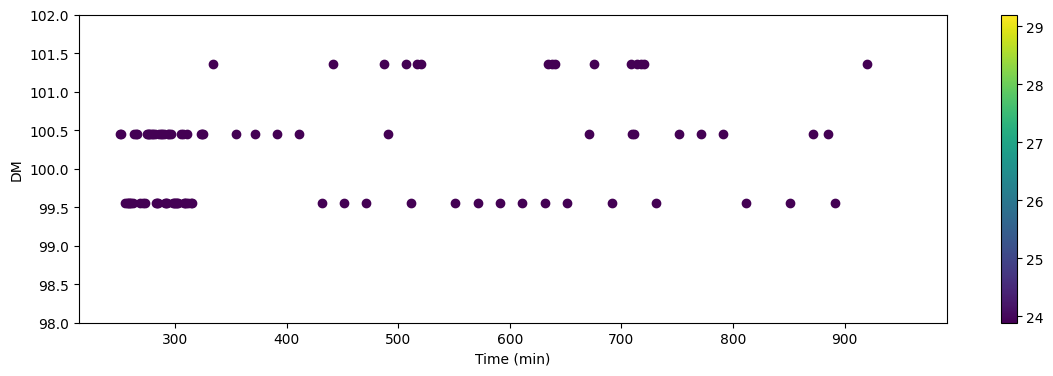

In [43]:
plt.figure(figsize=(14,4))

for i in range(len(fn)):
    #cand = np.loadtxt('/hdd/data/candidates/T2/{}'.format(fn[i]), unpack=True)
    tab = get_cand(fn[i])
    #plt.subplot(1,2,1)
    plt.scatter((tab['mjds']-60388)*24*60, tab['dm'], c=tab['snr'])
    #plt.xlim(4000,4600)
    #print(cand[3].min(), cand[3].max())
    plt.xlabel('Time (min)')
    plt.ylabel('DM')

plt.colorbar()
plt.ylim(98,102)
# plt.xlim(500,700)
# plt.axvline(552)
# plt.axvline(572)
# plt.axvline(592)


### Check how many injected pulses are detected in cluster_output.csv

In [12]:
cand = pd.read_csv('/hdd/data/candidates/T2/cluster_output.csv')
cand

snr         if    specnum          mjds  ibox   idm         dm  \
0       15.7039    4025558   16094604  60389.999648   128   650   654.8700   
1       16.3021    4025798   16095564  60389.999650   128   351   369.5600   
2       17.2737    4097286   16381516  60390.000083   256     1    50.9004   
3       23.1818    4097240   16381332  60390.000083   128     0    50.0000   
4       16.0973    4070564   16274628  60389.999921   256  1397  1489.8200   
...         ...        ...        ...           ...   ...   ...        ...   
248619  17.3073  180303034  721204508  60391.069326   128   644   648.9570   
248620  23.4258  180303023  721204464  60391.069326    64   645   649.9420   
248621  28.1650  180303033  721204504  60391.069326   128   645   649.9420   
248622  22.5407  180303023  721204464  60391.069326    64   646   650.9270   
248623  24.5669  180303030  721204492  60391.069326   128   646   650.9270   

        ibeam  cl  cntc  cntb trigger  
0           0   7    28     1       0  
1           0  19    29     1       0  
2           0  21    43     1       0  
3           0  22    14     1       0  
4           0  46    12     1       0  
...       ...  ..   ...   ...     ...  
248619      0  -1  1324     1       0  
248620      0  -1  1324     1       0  
248621      0  -1  1324     1       0  
248622      0  -1  1324     1       0  
248623      0  -1  1324     1       0  

[248624 rows x 12 columns]

In [14]:
# non triggered, all cands in T2
t = 880 # from how long ago in minutes 
tol = 2 # tolerance in seconds
cad = 900 # cadence in seconds
today = (cand['mjds']>(cand['mjds'].max()-t/60/24)) & (cand['dm']<101) & (cand['dm']>99) & (cand['cl']>0) 
cand_name = np.array([])
cand_mjd = cand[today].iloc[0,3] # cand[today]['mjds'][0:1].values[0]
i=0
while i < len(cand[today]):
    #print(trig[i], cand[today]['trigger'][trig[i]:trig[i]+1])
    current_time = cand[today].iloc[i,3] # mjd
    t_diff = np.abs(current_time-cand_mjd)*86400# time diff between two adjacent cands in sec
    print(t_diff)
    
    if (abs(cad - t_diff%cad)<tol) | (abs(cad - t_diff%cad)>(cad-tol)):
        #print(abs(cad - t_diff%cad))
        cand_name = np.append(cand_name, cand[today].iloc[i,11]) # trigger value
        cand_mjd = cand[today].iloc[i,3] # l cand[today]['mjds'][i:i+1].values[0]  # MJD value
        print('Cand i = ', i, cand[today].iloc[i,11])
        
    i+=1

0.0
Cand i =  0 240321aaqg
696.2000000523403
899.9999997904524
Cand i =  2 0
134.7999999532476
899.9999997904524
Cand i =  4 240321aaqy
22.299999743700027
900.0000004190952
Cand i =  6 240321aare
899.9999997904524
Cand i =  7 240321aarp
223.800000641495
899.9999997904524
Cand i =  9 240321aary
900.0000004190952
Cand i =  10 240321aasi
469.79999968316406
899.9999997904524
Cand i =  12 240321aass
899.9999997904524
Cand i =  13 240321aatc
900.0000004190952
Cand i =  14 240321aati
899.9999997904524
Cand i =  15 240321aatm
899.9999997904524
Cand i =  16 240321aatr
900.0000004190952
Cand i =  17 240321aaty
899.9999997904524
Cand i =  18 240321aauh
327.30000000447035
899.9999997904524
Cand i =  20 240321aaus
394.5000001229346
900.0000004190952
Cand i =  22 240321aava
227.19999980181456
691.3000002270564
899.9999997904524
Cand i =  25 240321aavl
899.9999997904524
Cand i =  26 240321aavr
103.3000004477799
4500.000000209548
Cand i =  28 240321aaxy
899.9999997904524
Cand i =  29 0
61.100000515580

In [15]:
print(np.unique(cand_name))
print(len(np.unique(cand_name)))
print('Detection probability = ', len(np.unique(cand_name))/(t//15))

['0' '240321aaqg' '240321aaqy' '240321aare' '240321aarp' '240321aary'
 '240321aasi' '240321aass' '240321aatc' '240321aati' '240321aatm'
 '240321aatr' '240321aaty' '240321aauh' '240321aaus' '240321aava'
 '240321aavl' '240321aavr' '240321aaxy' '240321aayv' '240321aazn'
 '240321aazz' '240321abau' '240321abbn' '240321abbu' '240321abcr'
 '240321abcx' '240321abdk' '240321abdt' '240321abef' '240321abfa'
 '240321abfk' '240321abgp' '240321abhc' '240321abhx' '240321abih'
 '240321abin' '240321abjk' '240322aabf' '240322aabq' '240322aacc'
 '240322aacq' '240322aadc']
43
Detection probability =  0.7413793103448276


Text(0, 0.5, 'DM')

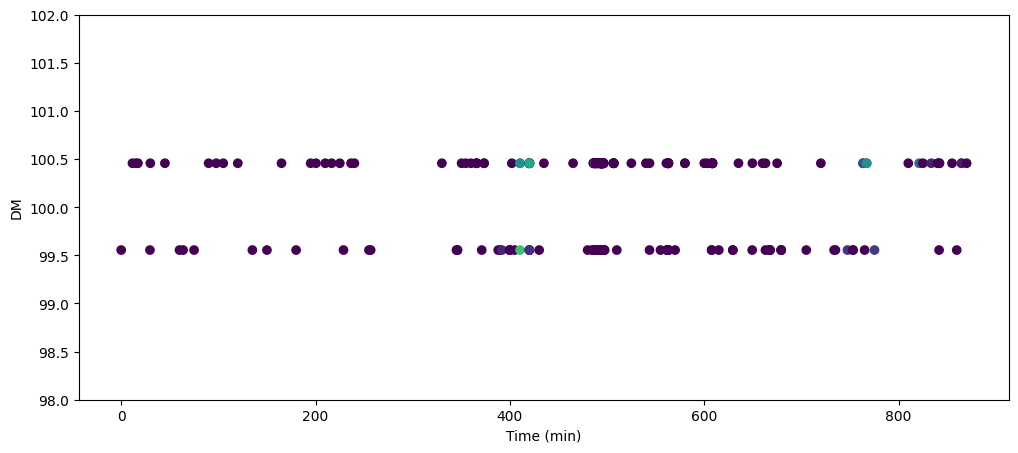

In [17]:
plt.figure(figsize=(12,5))
plt.scatter((cand[today]['mjds']-cand[today]['mjds'].min())*24*60, cand[today]['dm'], c=cand[today]['snr'])
plt.ylim(98,102)
plt.xlabel('Time (min)')
# plt.xlim(0, 40)
plt.ylabel("DM")

# Candidate ToA vs. NetCDF time

In [86]:
c = "240326aacf"
ff = "/hdd/data/voltages/grex_dump-"+c+".nc"
vol = xr.open_dataset(ff, chunks={"time":2048})

tab = get_cand(c+".json")
print(f"Between start time of voltage dump and candidate ToA, {(tab['mjds'].values[0] - vol.time.values.min()) * 86400} seconds")

Between start time of voltage dump and candidate ToA, 28.40313941705972 seconds


In [87]:
### plot .nc file to see if pulse is in it, despite the time discrepancy.
(vol, a, b) = ct.read_voltage_data("/hdd/data/voltages/grex_dump-240326aacf.nc", timedownsample=None,freqdownsample=None)

1280000 1360000


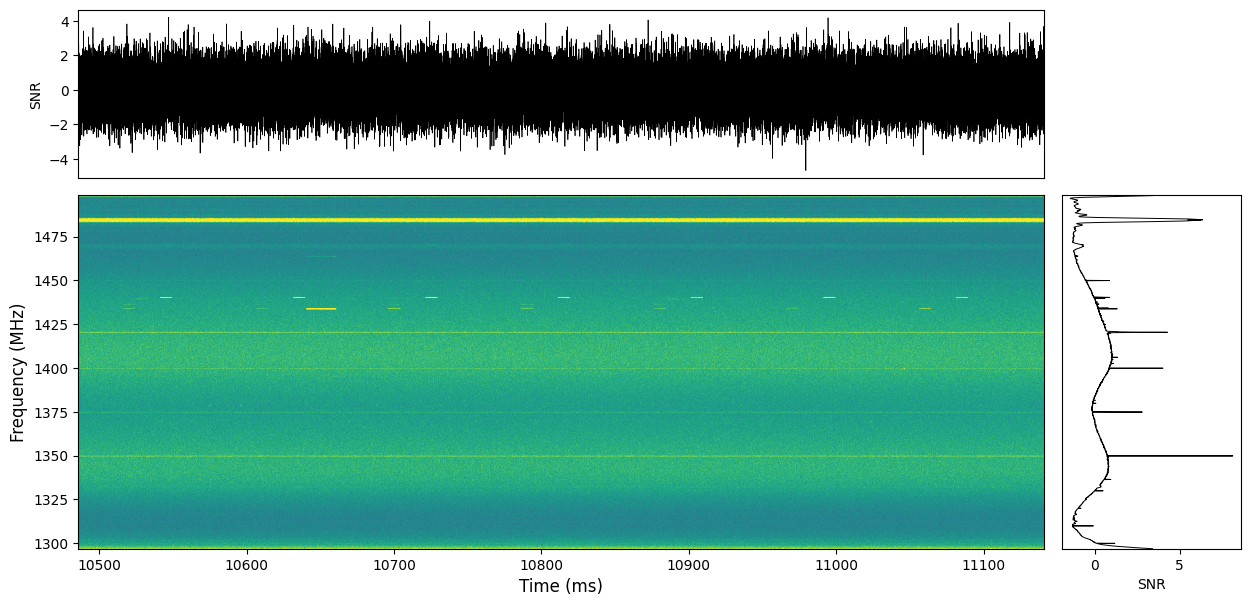

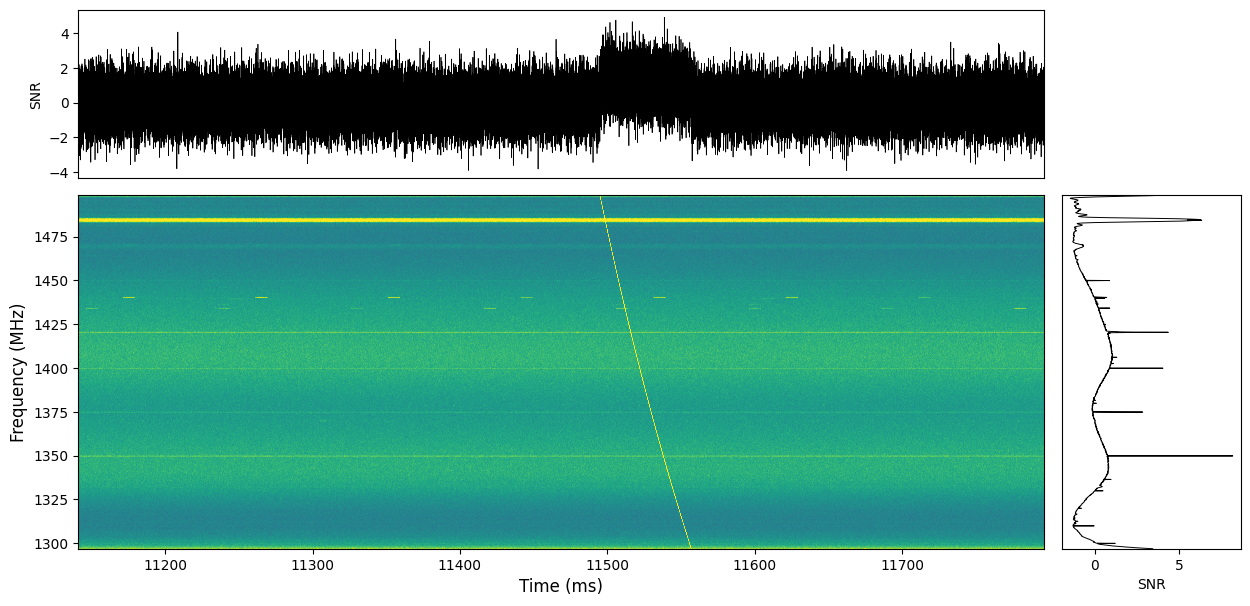

In [88]:
### faster
# plot 1500 time samples at a time (~ 12ms)
N = 17
# which chunk of time to plot (starting from 1)
ti_start = int((N-1)*80000) # 1500
ti_end   = ti_start+80000
t_start = vol.time[ti_start]
t_end   = vol.time[ti_end-1]
t0 = (t_start - vol.time[0])*86400*1e3 
Dt = (t_end-t_start) * 86400 * 1e3 #milli seconds
# data = stokesi.isel(time=np.arange(ti_start, ti_end), freq=np.arange(255, 1910)).voltages
data = vol[ti_start:ti_end, 255:1910]
print(ti_start, ti_end)
vmax = np.mean(data) + np.std(data)
plt.figure(figsize=(15,7))
grid = plt.GridSpec(3, 6, wspace=0.1, hspace=0.1)
plt.subplot(grid[0, :5])
data_favg = np.mean(data,axis=1)
plt.plot(vol.time[ti_start:ti_end], (data_favg - np.mean(data_favg)) / np.std(data_favg), lw=0.5, color='black')
# plt.xlabel('Time (ms)')
plt.ylabel('SNR')
plt.xlim(vol.time[ti_start:ti_end].min(), vol.time[ti_start:ti_end].max())
plt.xticks([], [])
plt.subplot(grid[1:, :5])
plt.imshow(data.T, aspect='auto', vmax=vmax,  extent=(t0, Dt+t0, vol.freq[255:1910].min(), vol.freq[255:1910].max()))
#plt.xlim(1966, 1967)
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Frequency (MHz)', fontsize=12)
plt.subplot(grid[1:, 5])
data_tavg = np.mean(data,axis=0)
plt.plot((data_tavg - np.mean(data_tavg)) / np.std(data_tavg), vol.freq[255:1910], lw=0.7, color='black')# plt.xlabel('Frequency (MHz)')
# plt.ylabel('SNR')
plt.xlabel('SNR')
plt.ylim(vol.freq[255:1910].min(), vol.freq[255:1910].max())
plt.yticks([], []);
plt.show()

N=N+1
ti_start = int((N-1)*80000)
ti_end   = ti_start+80000
t_start = vol.time[ti_start]
t_end   = vol.time[ti_end-1]
t0 = (t_start - vol.time[0])*86400*1e3 
Dt = (t_end-t_start) * 86400 * 1e3 #milli seconds
data = vol[ti_start:ti_end, 255:1910]
vmax = np.mean(data) + np.std(data)

plt.figure(figsize=(15,7))
grid = plt.GridSpec(3, 6, wspace=0.1, hspace=0.1)
plt.subplot(grid[0, :5])
data_favg = np.mean(data,axis=1)
plt.plot(vol.time[ti_start:ti_end], (data_favg - np.mean(data_favg)) / np.std(data_favg), lw=0.5, color='black')
# plt.xlabel('Time (ms)')
plt.ylabel('SNR')
plt.xlim(vol.time[ti_start:ti_end].min(), vol.time[ti_start:ti_end].max())
plt.xticks([], [])
plt.subplot(grid[1:, :5])
plt.imshow(data.T, aspect='auto', vmax=vmax,  extent=(t0, Dt+t0, vol.freq[255:1910].min(), vol.freq[255:1910].max()))
#plt.xlim(1966, 1967)
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Frequency (MHz)', fontsize=12)
plt.subplot(grid[1:, 5])
data_tavg = np.mean(data,axis=0)
plt.plot((data_tavg - np.mean(data_tavg)) / np.std(data_tavg), vol.freq[255:1910], lw=0.7, color='black')# plt.xlabel('Frequency (MHz)')
# plt.ylabel('SNR')
plt.xlabel('SNR')
plt.ylim(vol.freq[255:1910].min(), vol.freq[255:1910].max())
plt.yticks([], []);
plt.show()

In [74]:
## for a particular broadband RFI or solar burst? # in 240326aach N=3

data = data.astype('float64')

In [75]:
data -= np.mean(data, axis=0, keepdims=True)[0]

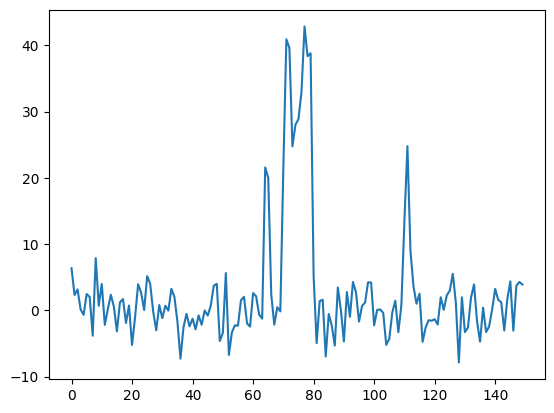

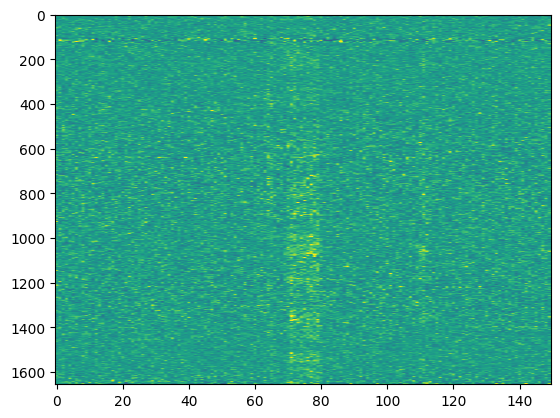

In [77]:
plt.plot(data[26300:26450,:].mean(axis=1))
plt.show()
plt.imshow(data[26300:26450,:].T, aspect='auto', vmax = vmax)

In [84]:
11.1 s after start of the nc file

11.1